In [13]:
!pip install pmdarima yfinance tensorflow scikit-learn matplotlib

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import datetime
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from tensorflow.keras import layers, Sequential, Input

In [18]:
"""
The reason I use the functions load_and_clean_data and get_date_range is that I couldn't run the auto ARIMA in my current VSCode setup.
Therefore, I used a Google Colab notebook to perform the modeling and validation process for TSLA.
"""

def load_and_clean_data(tickers, start_date, end_date):
    """Loads and cleans financial data for given tickers."""
    data_dict = {}
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)
        if data is not None and not data.empty:
            # Flatten MultiIndex columns
            data.columns = [col[0] for col in data.columns]
            #Use ffill() instead of fillna(method='ffill')
            data.ffill(inplace=True)
            data.index = pd.to_datetime(data.index)
            data_dict[ticker] = data
        else:
            print(f"No data found for {ticker}")
    return data_dict

def get_date_range(year_start = 2015, month_start= 1, day_start = 1, year_end = 2025, month_end = 1, day_end = 31):
    """Returns start and end datetime objects."""
    start_date = datetime.datetime(year_start, month_start, day_start)
    end_date = datetime.datetime(year_end, month_end, day_end)
    return start_date, end_date


tickers = ["TSLA"]
start_date, end_date = get_date_range()
data_dict = load_and_clean_data(tickers, start_date, end_date)
tsla_data = data_dict["TSLA"]

# 1. Data Preparation
tsla_close = tsla_data["Close"].values.reshape(-1, 1)

# Train-test split
train_size = int(len(tsla_close) * 0.8)
train_data, test_data = tsla_close[:train_size], tsla_close[train_size:]

[*********************100%***********************]  1 of 1 completed


In [19]:
# 2. Model Selection and Implementation (ARIMA)
# Auto ARIMA
auto_arima_model = auto_arima(train_data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
arima_order = auto_arima_model.order
print(f"Optimal ARIMA order: {arima_order}")

# Fit ARIMA model
arima_model = ARIMA(train_data, order=arima_order)
arima_fit = arima_model.fit()

# ARIMA Forecast
arima_forecast = arima_fit.forecast(steps=len(test_data))

# 2. Model Selection and Implementation (LSTM)
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

# LSTM Model
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), # Add input layer
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# LSTM Forecast
lstm_forecast_scaled = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled)
lstm_actual_test = scaler.inverse_transform(y_test)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12684.802, Time=3.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12680.726, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12679.653, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12679.753, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12678.997, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12680.805, Time=1.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.378 seconds
Optimal ARIMA order: (0, 1, 0)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [20]:
# 3. Model Evaluation
def evaluate_model(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    print(f"{model_name} MAE: {mae}")
    print(f"{model_name} RMSE: {rmse}")
    print(f"{model_name} MAPE: {mape}")

# ARIMA Evaluation
evaluate_model(test_data, arima_forecast, "ARIMA")

# LSTM Evaluation
evaluate_model(lstm_actual_test, lstm_forecast, "LSTM")

ARIMA MAE: 89.90958562546228
ARIMA RMSE: 111.07844416791498
ARIMA MAPE: 0.3461406742067283
LSTM MAE: 7.373965933049469
LSTM RMSE: 9.9895471917235
LSTM MAPE: 0.031634599415688615


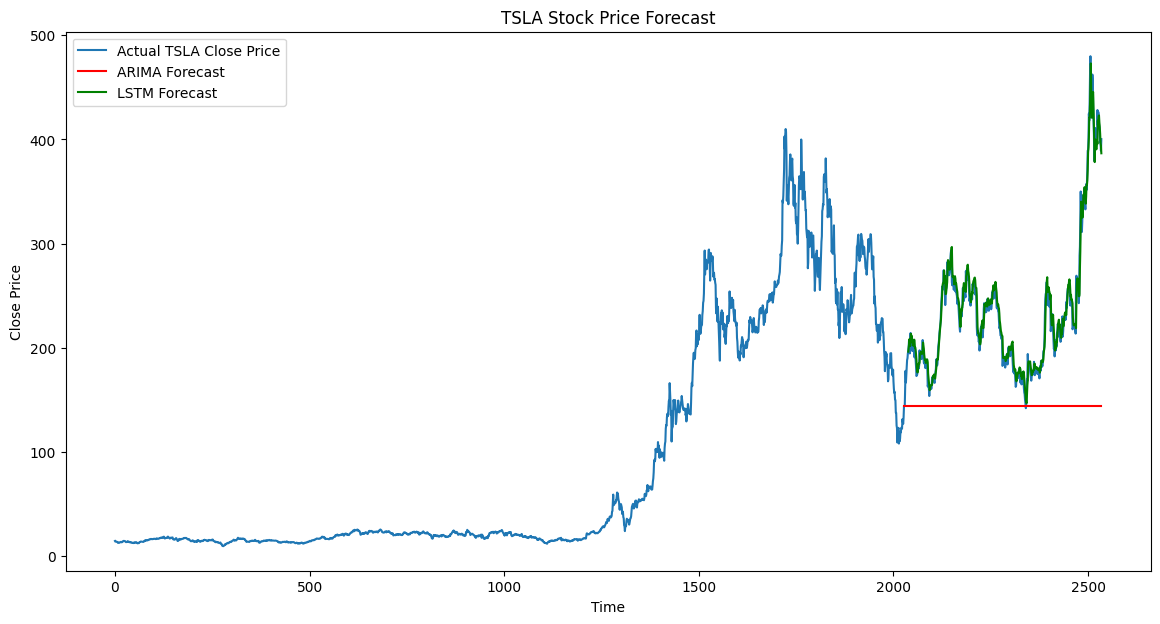

In [21]:
# 4. Visualization
plt.figure(figsize=(14, 7))
plt.plot(tsla_close, label='Actual TSLA Close Price')
plt.plot(range(train_size, len(tsla_close)), arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(range(train_size + seq_length, len(tsla_close)), lstm_forecast, label='LSTM Forecast', color='green')
plt.legend()
plt.title('TSLA Stock Price Forecast')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

**Detailed Insights from the Plot and Evaluation Metrics:**

**1. Visual Analysis of the Plot:**

* **LSTM's Accurate Tracking (Green Line):**
    * The LSTM forecast (green line) demonstrates a remarkable ability to track the actual TSLA closing prices (blue line) within the test set. The LSTM predictions align closely with the real price fluctuations, indicating its capacity to model the stock's volatile behavior.
* **ARIMA's Static and Inaccurate Forecast (Red Line):**
    * The ARIMA forecast (red line) is essentially a flat, horizontal line. This signifies that the ARIMA model fails to capture any of the dynamic changes in TSLA's stock price. It provides a constant, average prediction, which is far removed from the actual price movements.
* **Volatility and Trend Capture by LSTM:**
    * The LSTM model successfully mirrors the volatility present in the actual data. It accurately reflects both sharp rises and falls, demonstrating its proficiency in handling periods of significant price swings. Furthermore the LSTM model is shown to follow the trend of the data.
* **ARIMA's Lack of Responsiveness:**
    * In stark contrast, the ARIMA model remains unresponsive to the market's fluctuations. Its static forecast underscores its unsuitability for modeling the non-linear and volatile nature of TSLA's stock.

**2. Analysis of Evaluation Metrics:**

* **LSTM's Superior Performance:**
    * **MAE (Mean Absolute Error): 7.37:** On average, the LSTM's predictions are only 7.37 units away from the actual closing prices.
    * **RMSE (Root Mean Squared Error): 9.99:** The RMSE, which penalizes larger errors more heavily, is also low at 9.99.
    * **MAPE (Mean Absolute Percentage Error): 0.0316 or 3.16%:** The LSTM's predictions are, on average, within 3.16% of the actual prices. This reflects a high degree of accuracy.
* **ARIMA's Significant Prediction Errors:**
    * **MAE: 89.91:** The ARIMA model's predictions are, on average, 89.91 units away from the actual prices, indicating substantial errors.
    * **RMSE: 111.08:** The high RMSE further emphasizes the magnitude of the ARIMA model's prediction errors.
    * **MAPE: 0.3461 or 34.61%:** The ARIMA's predictions deviate from the actual prices by an average of 34.61%, highlighting its poor predictive performance.

**3. Integrated Insights:**

* **Model Suitability:**
    * The LSTM model is clearly the more suitable choice for forecasting TSLA's stock prices. Its ability to capture non-linear patterns and volatility is evident in both the plot and the evaluation metrics.
    * The ARIMA model, with its linear approach, fails to model the complexities of TSLA's stock behavior.
* **Accuracy and Reliability:**
    * The LSTM's low MAE, RMSE, and MAPE values, coupled with its accurate tracking in the plot, demonstrate its high accuracy and reliability.
    * The ARIMA's high error metrics and static forecast underscore its unreliability for this dataset.
* **Volatility Handling:**
    * The LSTM model is very good at short term predictions, and handling the volatility of the stock.
* **ARIMA's Limitations:**
    * The ARIMA model is shown to be very limited in its ability to predict the stock price.

**In summary:** The quantitative metrics and visual representation combine to give a clear and strong indication that the LSTM model is far superior to the ARIMA model when forecasting TSLA stock prices.
